<a href="https://www.kaggle.com/code/yuujapan/ver2-godaddy-microbusiness-density-forecasting?scriptVersionId=121291864" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
from sklearn import preprocessing

import warnings
warnings.simplefilter('ignore', FutureWarning)
import time

In [104]:
#データの読み込み
train=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
census=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

#activeの指数表記を直す
pd.options.display.float_format = '{:.6f}'.format
train["active"] = train["active"].astype(int)

#データを多く見れるようにする。
pd.set_option('display.max_rows', 5000)

print("OK!!")

OK!!


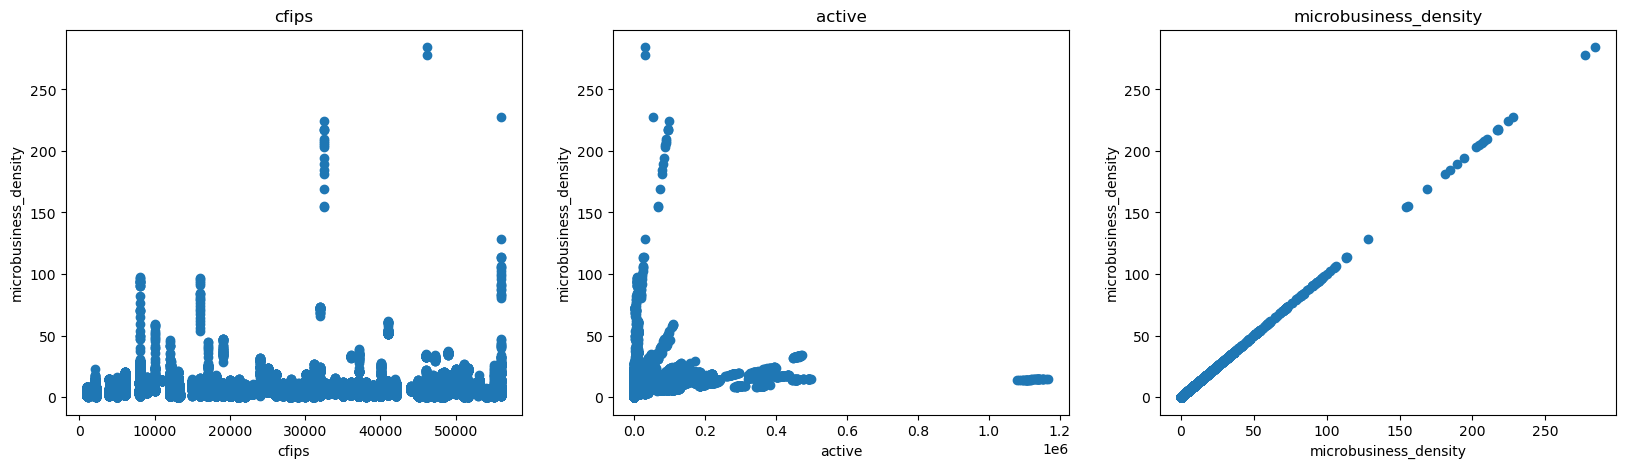

In [3]:
# グラフの大きさを指定する
plt.figure(figsize=(20, 5))
# 2つの特徴に1つの目的変数をつかう。
features = ["cfips", "active","microbusiness_density"]
target = train["microbusiness_density"]

# 2つのグラフを1ページで表示するため
#For文を使い、一つずつグラフ作っていく。
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = train[col] 
    y= target
    plt.scatter(x, y, marker="o")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("microbusiness_density")

<AxesSubplot:>

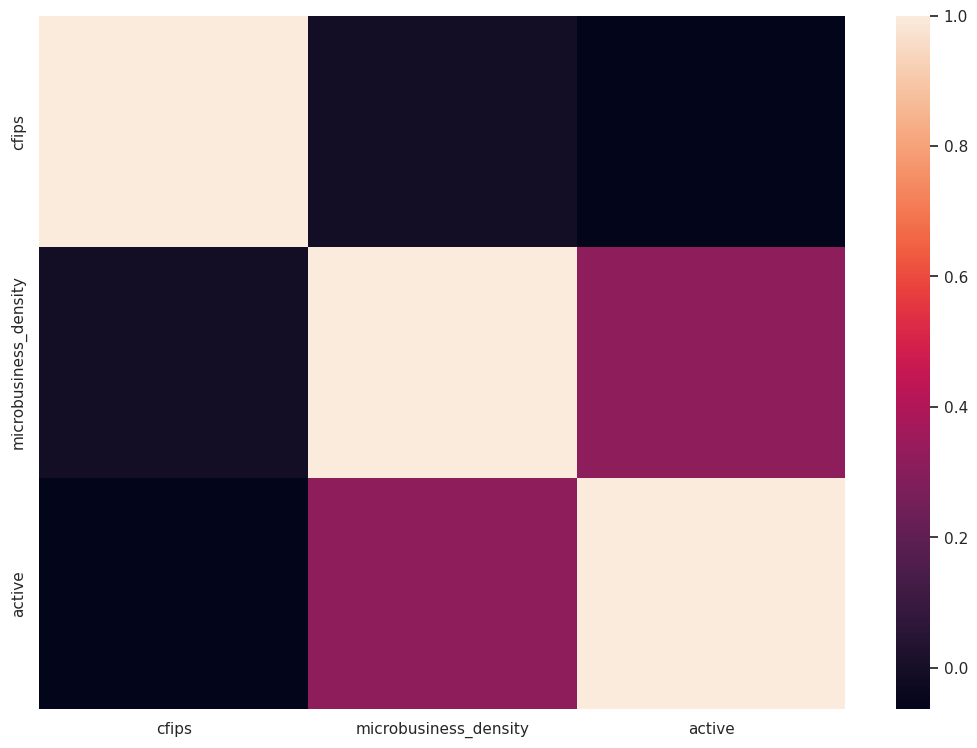

In [267]:
#データの相関関係図
#赤色が０
heatmap = train.corr()
sns.set(rc = {'figure.figsize':(13,9)})
sns.heatmap(heatmap)

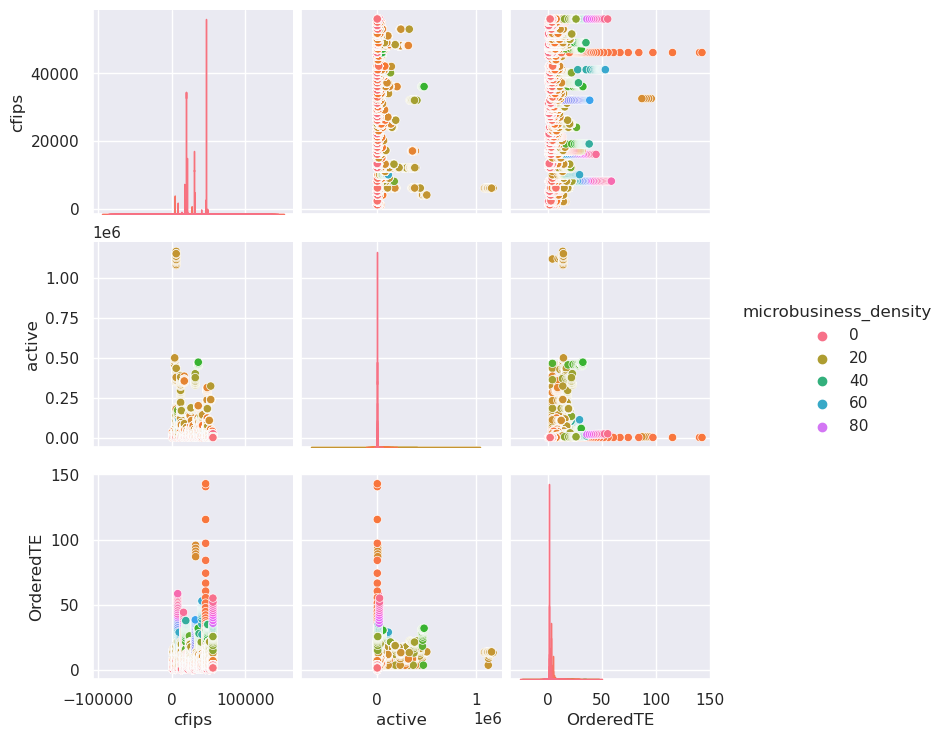

In [258]:
sns.pairplot(train, hue='microbusiness_density', palette="husl")

In [3]:
train.info()
print("--★--★--★--★--★---")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB
--★--★--★--★--★---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25080 entries, 0 to 25079
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              25080 non-null  object
 1   cfips               25080 non-null  int64 
 2   first_day_of_month  25080 n

In [4]:
#NaNの数を見る
train.isnull().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

In [5]:
#data数や平均値などを見る
train.describe()

,cfips,microbusiness_density,active
count,122265.000000,122265.000000,122265.000000
mean,30376.037640,3.817671,6442.858218
std,15143.508721,4.991087,33040.012493
min,1001.000000,0.000000,0.000000
25%,18177.000000,1.639344,145.000000
50%,29173.000000,2.586543,488.000000
75%,45077.000000,4.519231,2124.000000
max,56045.000000,284.340030,1167744.000000


In [6]:
train.nunique()

row_id                   122265
cfips                      3135
county                     1871
state                        51
first_day_of_month           39
microbusiness_density     97122
active                    19193
dtype: int64

In [7]:
train.astype('str').describe()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
count,122265,122265,122265,122265,122265,122265,122265
unique,122265,3135,1871,51,39,97122,19193
top,1001_2019-08-01,1001,Washington County,Texas,2019-08-01,0.0,33
freq,1,39,1170,9906,3135,26,327


In [8]:
test

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01
...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01
25076,56039_2023-06-01,56039,2023-06-01
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01


In [9]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


# **trainデータの作成**

In [105]:
#Train　＆train2　用
#行の数をカウント
#train["dcount"] = train.groupby(['cfips'])['row_id']

#ラグ特徴量
train["mbd_lag_1"] = train["microbusiness_density"].shift(1).fillna(0)

#ローリング特徴量
shifted = train["microbusiness_density"]
window = shifted.rolling(window=2)
roll_1 = window.mean()
train["roll_1"] = roll_1.fillna(0)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=3)
roll_2 = window.mean()
train["roll_2"] = roll_2.fillna(0)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=4)
roll_3 = window.mean()
train["roll_3"] = roll_3.fillna(0)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=5)
roll_4 = window.mean()
train["roll_4"] = roll_4.fillna(0)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=6)
roll_5 = window.mean()
train["roll_5"] = roll_5.fillna(0)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=7)
roll_6 = window.mean()
train["roll_6"] = roll_6.fillna(0)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=8)
roll_7 = window.mean()
train["roll_7"] = roll_7.fillna(0)

#mbd と mbd_lag_1 とのずれ量
train["deviation"] = train["microbusiness_density"] - train["mbd_lag_1"].fillna(0)

#cfipsごとの mbd 平均値
train["cat_mean"] = train.groupby('cfips')["microbusiness_density"].transform("mean")
train["cat_min"] = train.groupby('cfips')["microbusiness_density"].transform("min")
train["cat_max"] = train.groupby('cfips')["microbusiness_density"].transform("max")
train["cat_max-min"] = train["cat_max"] - train["cat_min"]

In [106]:
import category_encoders as ce

#ターゲットエンコーディング
te = ce.CatBoostEncoder(cols=['cfips'])
train['OrderedTE']= te.fit_transform(train['cfips'], train['microbusiness_density'])
print("OK!")


#Label エンコーディング
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
LE = le.fit_transform(train['state'])
LE = pd.Series(LE,name="state_LE")

print("OK!!!")
train = pd.concat([train, LE], axis=1)


#Label エンコーディング　２
le = LabelEncoder()
LE = le.fit_transform(train['county'])
LE = pd.Series(LE,name="county_LE")

print("OK!!!!!!")
train = pd.concat([train, LE], axis=1)

OK!
OK!!!
OK!!!!!!


In [107]:
#予測しきれていない mbdをリストアップ 
#divergenceを作成
#mbd_lag_1 - divergence の作成

Divergence = 3.0   #LightGBMの予想外範囲は50以上

md_filter = train[(train['microbusiness_density'] > Divergence)]   #mbd=??以上のdf
md_filter["divergence"] = md_filter["microbusiness_density"] - Divergence

md_filter2 = md_filter.index
md_filter2 =' '.join(map(str, md_filter2)).split()

train["divergence"] = train['microbusiness_density'].iloc[md_filter2] - Divergence
train["divergence"] = train["divergence"].fillna(0)

############
train['microbusiness_density'] = train['microbusiness_density'] - train["divergence"]
train["roll_1"] = train["roll_1"] - train["divergence"].shift(1)
train["roll_2"] = train["roll_2"] - train["divergence"].shift(2)
train["roll_3"] = train["roll_3"] - train["divergence"].shift(3)
train["roll_4"] = train["roll_4"] - train["divergence"].shift(4)
train["roll_5"] = train["roll_5"] - train["divergence"].shift(5)
train["roll_6"] = train["roll_6"] - train["divergence"].shift(6)
train["roll_7"] = train["roll_7"] - train["divergence"].shift(7)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [455]:
train['microbusiness_density'].describe()

count   122265.000000
mean         2.583897
std          1.086929
min          0.000000
25%          1.639344
50%          2.586543
75%          3.817671
max          3.817671
Name: microbusiness_density, dtype: float64

In [323]:
#予測しきれていないもの ＋削除
"""
md_filter = train[(train['microbusiness_density'] > Divergence)]  
print(len(md_filter))

mdarray = md_filter["cfips"].unique()
md_target = train[(train['cfips'].isin(mdarray))]
train = train.drop(md_target.index.unique())

1


In [10]:
#年月日の分割
"""
train['first_day_of_month'] = pd.to_datetime(train["first_day_of_month"])
train["year"] = train["first_day_of_month"].dt.year
train["month"] = train["first_day_of_month"].dt.month

In [ ]:
"""
#One-hot エンコーディング
ohe = pd.get_dummies(train['county'])
pd.concat([train, ohe], axis=1)

# # **分析用データ作成の開始**

**重回帰分析用DF作成**

In [97]:
#重回帰分析用2次元配列 DF
train2 = train[["active","cfips",'mbd_lag_1','OrderedTE',"deviation","county_LE","state_LE","divergence","cat_mean","cat_min","cat_max","cat_max-min","roll_1","roll_2","roll_3","roll_4","roll_5","roll_6","roll_7"]]
train2 = train2.replace([np.inf, -np.inf], np.nan).fillna(0)
    #無限大などの穴埋め

In [98]:
#トレーニングデータとテストデータの分割 train2
# .values で numpy配列に変換できる。
X_train, X_test, Y_train, Y_test = train_test_split(train2,train["microbusiness_density"], train_size=0.3, shuffle=False)

In [ ]:
#print(train.columns.tolist())

# **Train + Test データの作成と再分割**

In [108]:
#データ制作開始
#ローリング特徴量　結合前なので、ずれている分を戻しておく
shifted = train["microbusiness_density"]
window = shifted.rolling(window=2)
roll_1 = window.mean()
train["roll_1"] = roll_1.shift(-1)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=3)
roll_2 = window.mean()
train["roll_2"] = roll_2.shift(-2)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=4)
roll_3 = window.mean()
train["roll_3"] = roll_3.shift(-3)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=5)
roll_4 = window.mean()
train["roll_4"] = roll_4.shift(-4)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=6)
roll_5 = window.mean()
train["roll_5"] = roll_5.shift(-5)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=7)
roll_6 = window.mean()
train["roll_6"] = roll_6.shift(-6)

shifted = train["microbusiness_density"]
window = shifted.rolling(window=8)
roll_7 = window.mean()
train["roll_7"] = roll_7.shift(-7)

#Trainとtestの結合　train_test dfの作成

train_test = pd.DataFrame(index=[], columns=[])
#Trainデータとtestデータの区別ができるように。
train["train_or_test"] = 0
test["train_or_test"] = 1

#trainとtestの行を結合
train_test = pd.concat((train, test)).sort_values(["cfips",'row_id']).reset_index(drop=True).interpolate('ffill')
train_test["train_or_test"] = train_test["train_or_test"].fillna(1)

"""
train_test['first_day_of_month'] = pd.to_datetime(train_test["first_day_of_month"])
train_test["year"] = train_test["first_day_of_month"].dt.year
train_test["month"] = train_test["first_day_of_month"].dt.month
"""

#平均にする場合　＝ .transform('mean').ffill()
train_test["divergence"] = train_test.groupby('cfips')["divergence"].ffill()

train_test['mbd_lag_1'] = train_test.groupby('cfips')['mbd_lag_1'].ffill() 


train_test['OrderedTE'] = train_test.groupby('cfips')['OrderedTE'].ffill()
train_test['active'] = train_test.groupby('cfips')['active'].ffill()
train_test["deviation"] = train_test.groupby('cfips')['deviation'].ffill()

train_test["state_LE"] = train_test.groupby('cfips')['state_LE'].ffill()
train_test["county_LE"] = train_test.groupby('cfips')['county_LE'].ffill()

train_test["cat_mean"] = train_test.groupby('cfips')['cat_mean'].ffill()
train_test["cat_min"] = train_test.groupby('cfips')['cat_min'].ffill()
train_test["cat_max"] = train_test.groupby('cfips')['cat_max'].ffill()
train_test["cat_max-min"] = train_test.groupby('cfips')['cat_max-min'].ffill()


#結合したロール特徴量　をずらす。
train_test['roll_1'] = train_test.groupby('cfips')['roll_1'].ffill().shift(1) 
train_test['roll_2'] = train_test.groupby('cfips')['roll_2'].ffill().shift(2) 
train_test['roll_3'] = train_test.groupby('cfips')['roll_3'].ffill().shift(3) 
train_test['roll_4'] = train_test.groupby('cfips')['roll_4'].ffill().shift(4) 
train_test['roll_5'] = train_test.groupby('cfips')['roll_5'].ffill().shift(5) 
train_test['roll_6'] = train_test.groupby('cfips')['roll_6'].ffill().shift(6) 
train_test['roll_7'] = train_test.groupby('cfips')['roll_7'].ffill().shift(7) 

train_test['roll_1'] = train_test['roll_1'] - train_test["divergence"].shift(1)
train_test['roll_2'] = train_test['roll_2'] - train_test["divergence"].shift(2)
train_test['roll_3'] = train_test['roll_3'] - train_test["divergence"].shift(3)
train_test['roll_4'] = train_test['roll_4'] - train_test["divergence"].shift(4)
train_test['roll_5'] = train_test['roll_5'] - train_test["divergence"].shift(5)
train_test['roll_6'] = train_test['roll_6'] - train_test["divergence"].shift(6)
train_test['roll_7'] = train_test['roll_7'] - train_test["divergence"].shift(7)
    
#NaNの数を見る
train_test.isnull().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
mbd_lag_1                0
roll_1                   1
roll_2                   2
roll_3                   3
roll_4                   4
roll_5                   5
roll_6                   6
roll_7                   7
deviation                0
cat_mean                 0
cat_min                  0
cat_max                  0
cat_max-min              0
OrderedTE                0
state_LE                 0
county_LE                0
divergence               0
train_or_test            0
dtype: int64

In [103]:
train_test

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,mbd_lag_1,roll_1,roll_2,...,deviation,cat_mean,cat_min,cat_max,cat_max-min,OrderedTE,state_LE,county_LE,divergence,train_or_test
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.000000,1249.000000,0.000000,NaN,NaN,...,3.007682,3.164535,2.884870,3.463856,0.578985,3.817671,0.000000,82.000000,0.007682,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.000000,3.007682,2.934753,NaN,...,-0.122812,3.164535,2.884870,3.463856,0.578985,3.412676,0.000000,82.000000,0.000000,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.000000,1269.000000,2.884870,2.942435,2.953942,...,0.170973,3.164535,2.884870,3.463856,0.578985,3.236741,0.000000,82.000000,0.055843,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.000000,3.055843,2.940774,2.959368,...,-0.062610,3.164535,2.884870,3.463856,0.578985,3.191516,0.000000,82.000000,0.000000,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.000000,2.993233,2.993233,2.939646,...,0.000000,3.164535,2.884870,3.463856,0.578985,3.151860,0.000000,82.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,1.785395,100.000000,1.785395,1.785396,1.785395,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,1.785395,100.000000,1.785395,1.785396,1.785395,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,1.785395,100.000000,1.785395,1.785396,1.785395,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,1.785395,100.000000,1.785395,1.785396,1.785395,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1


In [109]:
#TrainとTestの再分割
#行番号の降り直し
train_test = train_test[train_test["train_or_test"] == 1].reset_index(drop=True)
train_test.index =  np.arange(1, len(train_test)+1)
 

In [110]:
#いらない列の削除 train_test
train_test = train_test.drop(["row_id","county","state","first_day_of_month","train_or_test"], axis=1)

In [111]:
#削除のみ
train_test = train_test.drop("microbusiness_density",axis=1)

In [57]:
train_test[25000:]

,cfips,active,mbd_lag_1,roll_1,roll_2,roll_3,roll_4,roll_5,roll_6,roll_7,deviation,cat_mean,cat_min,cat_max,cat_max-min,OrderedTE,state_LE,county_LE,divergence
25001,56027,32.000000,1.766595,2.356531,2.159886,2.061563,2.002570,1.954318,1.927501,1.907388,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25002,56027,32.000000,1.766595,2.356531,2.571021,2.369914,2.249250,2.168808,2.103701,2.061563,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25003,56027,32.000000,1.766595,2.356531,2.571021,2.678266,2.495931,2.374375,2.287550,2.215739,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25004,56027,32.000000,1.766595,2.356531,2.571021,2.678266,2.742612,2.579943,2.463750,2.376606,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25005,56027,32.000000,1.766595,2.356531,2.571021,2.678266,2.742612,2.785510,2.639951,2.530782,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25006,56027,32.000000,1.766595,2.356531,2.571021,2.678266,2.742612,2.785510,2.816152,2.684957,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25007,56027,32.000000,1.766595,2.356531,2.571021,2.678266,2.742612,2.785510,2.816152,2.839133,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25008,56027,32.000000,1.766595,2.356531,2.571021,2.678266,2.742612,2.785510,2.816152,2.839133,-0.053533,1.524188,1.150575,1.873662,0.723086,1.578152,50.000000,1194.000000,0.000000
25009,56029,1447.000000,6.178568,-0.217238,-0.178568,-0.221535,-0.191458,-0.101229,-0.058262,-0.023890,0.038670,6.010699,5.840142,6.290832,0.450690,5.949172,50.000000,1275.000000,3.217238
25010,56029,1447.000000,6.178568,-0.217238,-0.217238,-0.178568,-0.221535,-0.191458,-0.101229,-0.058262,0.038670,6.010699,5.840142,6.290832,0.450690,5.949172,50.000000,1275.000000,3.217238


# # **トレーニング・予測の開始**

In [17]:
!pip install optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [69]:
#ハイパーパラメーター  ランダムフォレスト
#回帰専用　＝ objective = regression に変更
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def objective(trial):
    max_features = trial.suggest_categorical("max_features", [None]) #'sqrt', 'log2'
    n_estimators = int(trial.suggest_discrete_uniform("n_estimators", 20,500,20))
    max_depth = trial.suggest_int("max_depth", 3,15)
    global clf
    
    #RandomForestRegressor
    clf = RandomForestRegressor(random_state=1, n_estimators = n_estimators, max_features = max_features, max_depth=max_depth)
    
    clf.fit(X_train, Y_train)
    return 1 - r2_score(Y_test, clf.predict(X_test)) 

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("---正答率---")
print(1-study.best_value)
print(study.best_params)

print("-----mean_squared_error----")
np.sqrt(mean_squared_error(Y_test,clf.predict(X_test)))

print("-----R2----1に近いほど良い")
r2 = r2_score(Y_test,clf.predict(X_test))
print('R2 :',r2)



[I 2023-03-03 04:04:40,404] A new study created in memory with name: no-name-99857e66-7b42-4f65-bea0-8f840b0c14f5
[W 2023-03-03 04:04:42,142] Trial 0 failed with parameters: {'max_features': None, 'n_estimators': 240.0, 'max_depth': 11} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_27/2371479503.py", line 16, in objective
    clf.fit(X_train, Y_train)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/paral

KeyboardInterrupt: 

[I 2023-03-07 01:02:06,411] A new study created in memory with name: no-name-aa5399a9-e12c-4728-8654-54896f238a95
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.00022564	valid_0's l2: 0.000333238


[I 2023-03-07 01:02:10,014] Trial 0 finished with value: 0.03547055126046772 and parameters: {'max_depth': 76, 'boosting_type': 'gbdt', 'min_child_samples': 706, 'max_bin': 3509, 'metric': 'l2'}. Best is trial 0 with value: 0.03547055126046772.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.000218603	valid_0's l2: 0.0003407


[I 2023-03-07 01:02:11,917] Trial 1 finished with value: 0.03626484305001709 and parameters: {'max_depth': 35, 'boosting_type': 'goss', 'min_child_samples': 604, 'max_bin': 5000, 'metric': 'l2'}. Best is trial 0 with value: 0.03547055126046772.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2023-03-07 01:02:16,182] Trial 2 finished with value: 0.654410518901697 and parameters: {'max_depth': 85, 'boosting_type': 'dart', 'min_child_samples': 580, 'max_bin': 3294, 'metric': 'l2'}. Best is trial 0 with value: 0.03547055126

Training until validation scores don't improve for 100 rounds


[I 2023-03-07 01:02:17,796] Trial 3 finished with value: 0.03912558813076972 and parameters: {'max_depth': 39, 'boosting_type': 'goss', 'min_child_samples': 720, 'max_bin': 4818, 'metric': 'l2'}. Best is trial 0 with value: 0.03547055126046772.


Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.000255948	valid_0's l2: 0.000367576


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds


[I 2023-03-07 01:02:19,031] Trial 4 finished with value: 0.047278034874546626 and parameters: {'max_depth': 96, 'boosting_type': 'goss', 'min_child_samples': 811, 'max_bin': 3515, 'metric': 'l2'}. Best is trial 0 with value: 0.03547055126046772.


Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.000302211	valid_0's l2: 0.000444167


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds


[I 2023-03-07 01:02:20,486] Trial 5 finished with value: 0.04583362724663953 and parameters: {'max_depth': 90, 'boosting_type': 'goss', 'min_child_samples': 749, 'max_bin': 4551, 'metric': 'l2'}. Best is trial 0 with value: 0.03547055126046772.


Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.000296316	valid_0's l2: 0.000430597


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds


[I 2023-03-07 01:02:22,144] Trial 6 finished with value: 0.03396127673742766 and parameters: {'max_depth': 96, 'boosting_type': 'goss', 'min_child_samples': 618, 'max_bin': 4439, 'metric': 'l2'}. Best is trial 6 with value: 0.03396127673742766.


Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.000207375	valid_0's l2: 0.000319059


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2023-03-07 01:02:26,747] Trial 7 finished with value: 0.6594511512418167 and parameters: {'max_depth': 84, 'boosting_type': 'dart', 'min_child_samples': 639, 'max_bin': 3038, 'metric': 'l2'}. Best is trial 6 with value: 0.03396127673742766.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.000291953	valid_0's l2: 0.000437869


[I 2023-03-07 01:02:29,711] Trial 8 finished with value: 0.04660764773448711 and parameters: {'max_depth': 65, 'boosting_type': 'gbdt', 'min_child_samples': 830, 'max_bin': 3915, 'metric': 'l2'}. Best is trial 6 with value: 0.03396127673742766.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds


[I 2023-03-07 01:02:31,463] Trial 9 finished with value: 0.03972107462660979 and parameters: {'max_depth': 12, 'boosting_type': 'gbdt', 'min_child_samples': 770, 'max_bin': 3128, 'metric': 'l2'}. Best is trial 6 with value: 0.03396127673742766.


Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.000253827	valid_0's l2: 0.000373171
---正答率---
0.9660387232625723
{'max_depth': 96, 'boosting_type': 'goss', 'min_child_samples': 618, 'max_bin': 4439, 'metric': 'l2'}


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

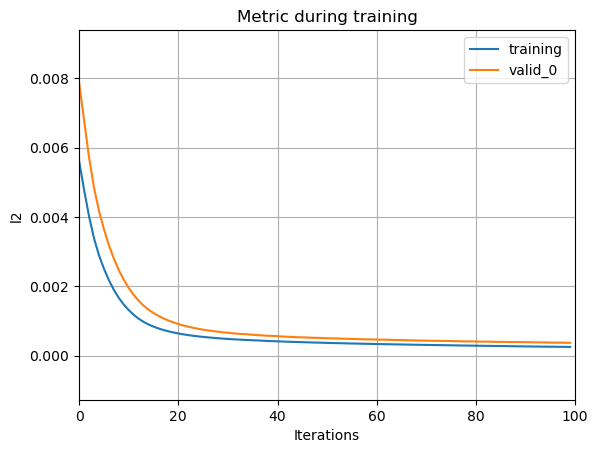

In [73]:
#ハイパーパラメーター  LightGBM
#回帰専用　＝ objective = regression に変更
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def objective(trial):
    max_depth = trial.suggest_int("max_depth", 10,100)
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt","dart","goss"])
    #learning_rate = trial.suggest_float("learning_rate", 0.005,0.0075)  #使うと成績が悪くなる。
    min_child_samples = trial.suggest_int("min_child_samples", 200,1000)
    max_bin = trial.suggest_int("max_bin", 3000,5000) #default 255
    metric = trial.suggest_categorical("metric", ["l2"])
    global clf
    
    #LGBMRegressor
    clf = lgb.LGBMRegressor(metric=metric,max_bin=max_bin,min_child_samples=min_child_samples ,boosting_type = boosting_type, max_depth=max_depth,random_seed=42)

    clf.fit(X_train, Y_train,eval_set=[(X_test, Y_test), (X_train, Y_train)],eval_metric= "l2",verbose=False,callbacks=[lgb.early_stopping(stopping_rounds=100)])
    return 1 - r2_score(Y_test, clf.predict(X_test)) 

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("---正答率---")
print(1-study.best_value)
print(study.best_params)

lgb.plot_metric(clf)

In [99]:
#XGBoost   mbd = 45以上が外れる。

#ハイパーパラメーター  XGBoost
#回帰専用　＝ objective = regression に変更
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def objective(trial):
    max_depth = trial.suggest_int("max_depth", 10,100)
    gamma = trial.suggest_float("gamma", 0,0.2)

    global clf
    
    #LGBMRegressor
    clf = xgb.XGBRegressor(max_depth = max_depth,gamma = gamma, early_stopping_rounds=10)

    clf.fit(X_train, Y_train,eval_set=[(X_test, Y_test), (X_train, Y_train)],verbose=False)
    return 1 - r2_score(Y_test, clf.predict(X_test)) 

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("---正答率---")
print(1-study.best_value)
print(study.best_params)


[I 2023-03-07 01:07:00,733] A new study created in memory with name: no-name-62964c61-24a7-43f2-8014-40c6ff6e0195
[I 2023-03-07 01:07:30,590] Trial 0 finished with value: 0.0009831986409495341 and parameters: {'max_depth': 44, 'gamma': 0.028231290788920282}. Best is trial 0 with value: 0.0009831986409495341.
[I 2023-03-07 01:08:00,279] Trial 1 finished with value: 0.0009650857987567596 and parameters: {'max_depth': 72, 'gamma': 0.08917772532859876}. Best is trial 1 with value: 0.0009650857987567596.
[I 2023-03-07 01:08:14,620] Trial 2 finished with value: 0.000988108689875089 and parameters: {'max_depth': 14, 'gamma': 0.04476738317672446}. Best is trial 1 with value: 0.0009650857987567596.
[I 2023-03-07 01:08:39,818] Trial 3 finished with value: 0.0010029071784145582 and parameters: {'max_depth': 90, 'gamma': 0.1398589741357595}. Best is trial 1 with value: 0.0009650857987567596.
[I 2023-03-07 01:08:52,308] Trial 4 finished with value: 0.0010917680833946175 and parameters: {'max_depth'

---正答率---
0.9990441229893167
{'max_depth': 66, 'gamma': 0.03610188370011169}


1   roll_1   0.56683713
2   cat_mean   0.18302538
3   mbd_lag_1   0.1794586
4   divergence   0.042268753
5   cat_max   0.011411752
6   cat_min   0.009220017
7   deviation   0.003114844
8   active   0.002500175
9   roll_3   0.00085072435
10   county_LE   0.0005296612
11   cat_max-min   0.0004791196
12   roll_2   0.00030384425
13   roll_6   0.0
14   state_LE   0.0
15   roll_4   0.0
16   OrderedTE   0.0
17   roll_5   0.0
18   cfips   0.0
19   roll_7   0.0


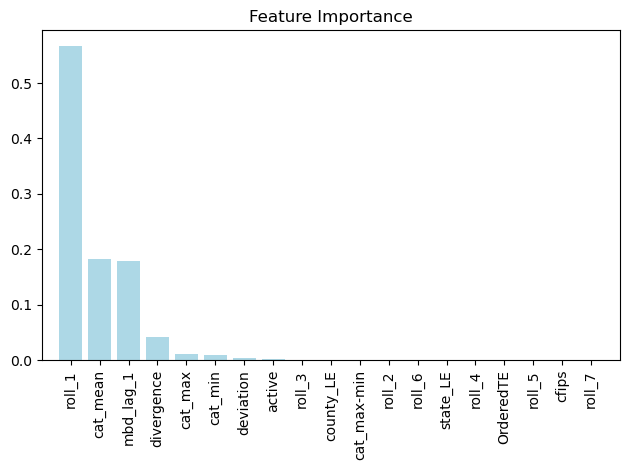

Index(['active', 'cfips', 'mbd_lag_1', 'OrderedTE', 'deviation', 'county_LE',
       'state_LE', 'divergence', 'cat_mean', 'cat_min', 'cat_max',
       'cat_max-min', 'roll_1', 'roll_2', 'roll_3', 'roll_4', 'roll_5',
       'roll_6', 'roll_7'],
      dtype='object')


In [100]:
import matplotlib.pyplot as plt
#特徴量の重要度
feature = clf.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)

#特徴量の名前
label = X_train.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()
print(label)


,Data,Predicted
36679,1.135826,1.144022
36680,1.230478,1.242720
36681,1.230478,1.227311
36682,1.230478,1.227311
36683,1.230478,1.227311
...,...,...
122260,1.803249,1.814750
122261,1.803249,1.814750
122262,1.785395,1.806582
122263,1.785395,1.773960


Text(0.5, 1.0, 'y vs y_pred')

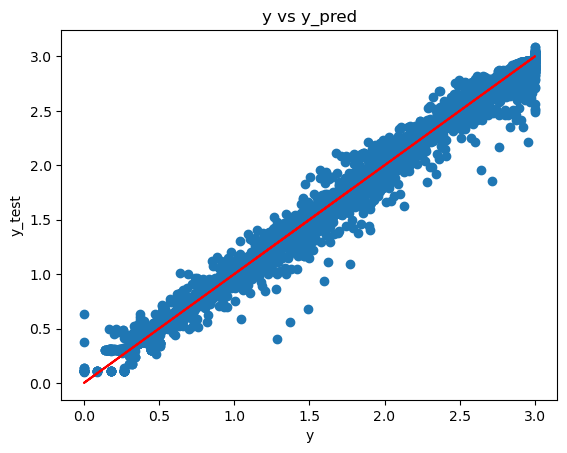

In [101]:

# 真値と予測値の表示
y_pred = clf.predict(X_test)
df_pred = pd.DataFrame({'Data':Y_test,'Predicted':y_pred})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(Y_test, Y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(Y_test, y_pred) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_test') # y軸ラベル
plt.title('y vs y_pred') # グラフタイトル


In [102]:
Y_test.describe()

count   85586.000000
mean        2.288188
std         0.789917
min         0.000000
25%         1.642984
50%         2.596626
75%         3.000000
max         3.000000
Name: microbusiness_density, dtype: float64

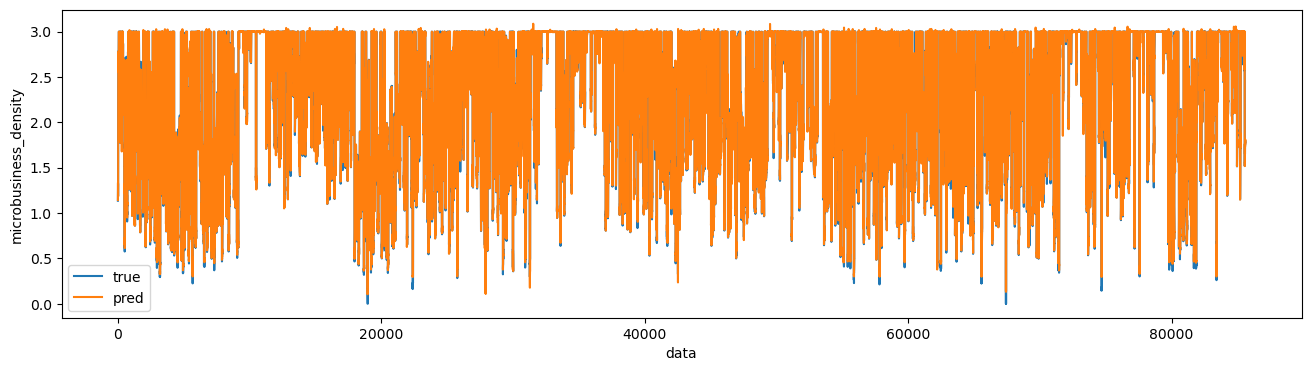

In [103]:
# 予測値と実測値の折れ線図
plt.figure(figsize=(16,4))
plt.plot(Y_test.reset_index(drop=True), label='true')
plt.plot(y_pred, label='pred')

plt.xlabel('data')
plt.ylabel('microbusiness_density')
# plt.xlim(0,1000)
plt.legend()

plt.show()

In [22]:
train_test[0:50]

NameError: name 'train_test' is not defined

In [273]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_7"] = clf.predict(train_test[x:x+1])
        
    if x % 1000 == 0:
        print(x)
        
    elif (x+1) % 8 == 0:
        continue
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [275]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_6"] = clf.predict(train_test[x:x+1])
        
    if x % 1000 == 0:
        print(x)
        
    elif (x+1) % 8 == 0:
        continue
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [276]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_5"] = clf.predict(train_test[x:x+1])
        
    if x % 1000 == 0:
        print(x)
        
    elif (x+1) % 8 == 0:
        continue
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [277]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_4"] = clf.predict(train_test[x:x+1])
        
    if x % 1000 == 0:
        print(x)
        
    elif (x+1) % 8 == 0:
        continue
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [278]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_3"] = clf.predict(train_test[x:x+1])
        
    if x % 1000 == 0:
        print(x)
        
    elif (x+1) % 8 == 0:
        continue
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [279]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_2"] = clf.predict(train_test[x:x+1])

    if x % 1000 == 0:
        print(x)
    elif (x+1) % 8 == 0:
        continue

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [280]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_1"] = clf.predict(train_test[x:x+1])
    
    if x % 1000 == 0:
        print(x)
    
    elif (x+1) % 8 == 0:
        continue

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


# **実際に予測する**

In [112]:
#実際に予測する
#test = test.drop("microbusiness_density",axis=1)
train_test = train_test.dropna()
train_test = train_test.drop(train_test.index[25080:])
predicted_2 = clf.predict(train_test)
predicted_2

array([2.9963171, 2.9963171, 2.9963171, ..., 1.8330727, 1.8330727,
       1.8330727], dtype=float32)

In [113]:
predicted_2[0:50]

array([2.9963171 , 2.9963171 , 2.9963171 , 2.9963171 , 2.9963171 ,
       2.9963171 , 2.9963171 , 2.9963171 , 2.9357054 , 2.9357054 ,
       2.9357054 , 2.9357054 , 2.9357054 , 2.9357054 , 2.9357054 ,
       2.9357054 , 1.3450178 , 1.3450178 , 1.3450178 , 1.3450178 ,
       1.3450178 , 1.3450178 , 1.3450178 , 1.3450178 , 1.5758888 ,
       1.6471074 , 1.7778742 , 2.0028806 , 2.0028806 , 2.0028806 ,
       2.0028806 , 2.0028806 , 2.1048603 , 2.1048603 , 2.1048603 ,
       1.5369666 , 1.5262303 , 1.385952  , 1.385952  , 1.385952  ,
       0.80495226, 0.80495226, 0.80495226, 0.80495226, 0.80495226,
       0.80495226, 0.80495226, 0.80495226, 2.578134  , 2.914662  ],
      dtype=float32)

In [114]:
#DFに書き込むためのデータを呼び出す。
test2 = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
test2 = test2.sort_values(["cfips","first_day_of_month"],ascending=True)

In [115]:
#答えをDFにする
test2["microbusiness_density"] = predicted_2

#df_answer = pd.DataFrame(data={"row_id":test2["row_id"],,"microbusiness_density":predicted_2})
#df_answer

#答えをソート　提出例に合わせて作る
test2 = test2.sort_values(["first_day_of_month","cfips"])
#test2 = test2.drop(["first_day_of_month","cfips"],axis=1)

In [116]:
#Divergence　ずれを反映させるためのdf。
test3 = pd.DataFrame(data=[])
test3["cfips"] = md_filter["cfips"]  #mbd=?? 以上のdf のcfips ユニーク値
test3["divergence"] = md_filter["divergence"] # すれ 
test3 = test3.drop_duplicates(subset='cfips')   #重複行の削除

#テストデータとdivergenceを結合後、予測したmbdに足す。

In [101]:
list(md_filter["divergence"].unique())

[1.5076817999999998,
 1.3848701,
 1.5558431000000001,
 1.4932332000000001,
 1.46909,
 1.4093255999999998,
 1.4332314,
 1.5001674,
 1.5049484,
 1.5192918999999998,
 1.5838373,
 1.6746789999999998,
 1.7057563999999998,
 1.6938035,
 1.5384164,
 1.502558,
 1.4472437,
 1.6061055999999998,
 1.6440427,
 1.7246592,
 1.7270303,
 1.7222881,
 1.7104328,
 1.7199171,
 1.686722,
 1.7033195,
 1.7009485,
 1.7863071000000001,
 1.7967808,
 1.8344314000000002,
 1.8367846,
 1.8720819999999998,
 1.8132529000000002,
 1.8461973999999999,
 1.9379705999999999,
 1.9238517000000002,
 1.9426770000000002,
 1.9638555000000002,
 5.7391562,
 5.7909365,
 5.9254394,
 5.9260707,
 5.9702735,
 5.9136553,
 5.7825217,
 5.8096104,
 6.068799,
 6.1032753,
 6.2085514,
 6.2830448,
 6.353229,
 6.912239100000001,
 6.8291264,
 6.7632522999999996,
 6.7244663,
 6.511044500000001,
 6.4090009,
 6.4780307,
 6.5326538,
 6.5614662,
 6.5770731,
 6.4840331,
 6.4186049,
 6.302155,
 6.3321676,
 6.4005971,
 6.4300098,
 6.233397,
 6.3232999,
 6

In [117]:
#test2 と test3　をマージ
test4 = pd.merge(test2, test3,on='cfips',how='outer')
test4["divergence"] = test4["divergence"].fillna(0)

test4 = test4.sort_values(["first_day_of_month","cfips"])
test4["microbusiness_density"] = test4["microbusiness_density"] + test4["divergence"]
test5 = test4.drop(["first_day_of_month","cfips","divergence"],axis=1)
test5 = test5.reset_index(drop=True)
test5

,row_id,microbusiness_density
0,1001_2022-11-01,3.003999
1,1003_2022-11-01,7.174862
2,1005_2022-11-01,1.345018
3,1007_2022-11-01,1.575889
4,1009_2022-11-01,2.104860
...,...,...
25075,56037_2023-06-01,2.961382
25076,56039_2023-06-01,26.369068
25077,56041_2023-06-01,4.604479
25078,56043_2023-06-01,3.009367


In [709]:
sample

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671
...,...,...
25075,56037_2023-06-01,3.817671
25076,56039_2023-06-01,3.817671
25077,56041_2023-06-01,3.817671
25078,56043_2023-06-01,3.817671


In [118]:
test4.sort_values(["cfips","row_id"])[0:20]

,row_id,cfips,first_day_of_month,microbusiness_density,divergence
0,1001_2022-11-01,1001,2022-11-01,3.003999,0.007682
1,1001_2022-12-01,1001,2022-12-01,3.003999,0.007682
2,1001_2023-01-01,1001,2023-01-01,3.003999,0.007682
3,1001_2023-02-01,1001,2023-02-01,3.003999,0.007682
4,1001_2023-03-01,1001,2023-03-01,3.003999,0.007682
5,1001_2023-04-01,1001,2023-04-01,3.003999,0.007682
6,1001_2023-05-01,1001,2023-05-01,3.003999,0.007682
7,1001_2023-06-01,1001,2023-06-01,3.003999,0.007682
8,1003_2022-11-01,1003,2022-11-01,7.174862,4.239156
9,1003_2022-12-01,1003,2022-12-01,7.174862,4.239156


In [119]:
#完成したCSVを名前を変えて保存する #インデックス（行番号）なし
test5.to_csv('/kaggle/working/godaddy90.csv',index = False)

In [158]:
import pickle
#学習モデルの保存
with open('/kaggle/working/godaddy.pickle', mode='wb') as f:
    pickle.dump(clf,f,protocol=2)

In [54]:
import pickle
# モデルのオープン
with open('/kaggle/working/godaddy.pickle', mode='rb') as f:
    clf = pickle.load(f)

**censusからmicrobusinessdensityを予測。**

In [124]:
census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.600000,78.900000,80.600000,82.700000,85.500000,1001,14.500000,15.900000,16.100000,16.700000,...,1.300000,1.100000,0.700000,0.600000,1.100000,55317,58786.000000,58731,57982.000000,62660.000000
1,74.500000,78.100000,81.800000,85.100000,87.900000,1003,20.400000,20.700000,21.000000,20.200000,...,1.400000,1.300000,1.400000,1.000000,1.300000,52562,55962.000000,58320,61756.000000,64346.000000
2,57.200000,60.400000,60.500000,64.600000,64.600000,1005,7.600000,7.800000,7.600000,7.300000,...,0.500000,0.300000,0.800000,1.100000,0.800000,33368,34186.000000,32525,34990.000000,36422.000000
3,62.000000,66.100000,69.200000,76.100000,74.600000,1007,8.100000,7.600000,6.500000,7.400000,...,1.200000,1.400000,1.600000,1.700000,2.100000,43404,45340.000000,47542,51721.000000,54277.000000
4,65.800000,68.500000,73.000000,79.600000,81.000000,1009,8.700000,8.100000,8.600000,8.900000,...,1.300000,1.400000,0.900000,1.100000,0.900000,47412,48695.000000,49358,48922.000000,52830.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.200000,82.400000,84.000000,86.700000,88.400000,56037,15.300000,15.200000,14.800000,13.700000,...,0.600000,0.600000,1.000000,0.900000,1.000000,71083,73008.000000,74843,73384.000000,76668.000000
3138,83.500000,85.900000,87.100000,89.100000,90.500000,56039,37.700000,37.800000,38.900000,37.200000,...,0.700000,1.200000,1.400000,1.500000,2.000000,80049,83831.000000,84678,87053.000000,94498.000000
3139,83.800000,88.200000,89.500000,91.400000,90.600000,56041,11.900000,10.500000,11.100000,12.600000,...,1.200000,1.200000,1.400000,1.700000,0.900000,54672,58235.000000,63403,72458.000000,75106.000000
3140,76.400000,78.300000,78.200000,82.800000,85.400000,56043,15.400000,15.000000,15.400000,15.000000,...,1.300000,1.000000,0.900000,0.900000,1.100000,51362,53426.000000,54158,57306.000000,62271.000000


In [127]:
#trainとcensusの結合

train3 = pd.merge(train,census, on='cfips').fillna(0)
#train3.isnull().sum()
train3.drop(["row_id","county","state","first_day_of_month"])

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
mbd_lag_1                0
OrderedTE                0
pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              0
pct_bb_2021              0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         0
pct_college_2021         0
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    0
pct_foreign_born_2021    0
pct_it_workers_2017      0
pct_it_workers_2018      0
pct_it_workers_2019      0
pct_it_workers_2020      0
pct_it_workers_2021      0
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
median_hh_inc_2021       0
dtype: int64

In [128]:
train3

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,mbd_lag_1,OrderedTE,pct_bb_2017,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,0.000000,3.817671,76.600000,...,1.300000,1.100000,0.700000,0.600000,1.100000,55317,58786.000000,58731,57982.000000,62660.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,3.007682,3.412676,76.600000,...,1.300000,1.100000,0.700000,0.600000,1.100000,55317,58786.000000,58731,57982.000000,62660.000000
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2.884870,3.236741,76.600000,...,1.300000,1.100000,0.700000,0.600000,1.100000,55317,58786.000000,58731,57982.000000,62660.000000
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,3.055843,3.191516,76.600000,...,1.300000,1.100000,0.700000,0.600000,1.100000,55317,58786.000000,58731,57982.000000,62660.000000
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2.993233,3.151860,76.600000,...,1.300000,1.100000,0.700000,0.600000,1.100000,55317,58786.000000,58731,57982.000000,62660.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121181,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,1.803249,1.706618,71.100000,...,0.600000,0.600000,0.000000,0.000000,0.000000,59605,52867.000000,57031,53333.000000,65566.000000
121182,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,1.803249,1.709302,71.100000,...,0.600000,0.600000,0.000000,0.000000,0.000000,59605,52867.000000,57031,53333.000000,65566.000000
121183,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,1.803249,1.711841,71.100000,...,0.600000,0.600000,0.000000,0.000000,0.000000,59605,52867.000000,57031,53333.000000,65566.000000
121184,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,1.785395,1.713777,71.100000,...,0.600000,0.600000,0.000000,0.000000,0.000000,59605,52867.000000,57031,53333.000000,65566.000000


# # **コードのメモ**

In [ ]:
#trainとcensusの結合
"""
train = pd.merge(train,census, on='cfips').fillna(0)
train.isnull().sum()
"""

In [ ]:
#予測しきれていない mbdをリストアップ
md_filter = train[(train['microbusiness_density'] > 30)]
print(len(md_filter))

#リストアップして,同じcfipsのものを全削除
mdarray2 = set(md_filter["cfips"].index) & set(md_filter['cfips'].index) #setで行番号を比較、辞書形式になる。

mdarray2= list(mdarray2)                          #辞書からリストに直す。
' '.join(map(str, mdarray2)).split()              #文字列に変換して、スペースでsplit
print(len(mdarray2))

train = train.drop(train.index[mdarray2],axis=0)  #行番号を指定して削除

In [ ]:
train.loc[(train['microbusiness_density'] > 20),['microbusiness_density']] = train['microbusiness_density']-20
#df1.loc[df1["c3"]>3, ["c3"]]=1
md_filter

# **ARIMA モデル**

In [94]:
#データの読み込み
train=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
census=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

#activeの指数表記を直す
pd.options.display.float_format = '{:.6f}'.format
train["active"] = train["active"].astype(int)

In [11]:
#ARIMA自己回帰　　インストール時間かかる
!pip install git+https://github.com/RJT1990/pyflux

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-ewkq014t
  Running command git clone --filter=blob:none --quiet https://github.com/RJT1990/pyflux /tmp/pip-req-build-ewkq014t
  Resolved https://github.com/RJT1990/pyflux to commit 297f2afc2095acd97c12e827dd500e8ea5da0c0f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.9 MB/s eta 0:00:00
  Created wheel for pyflux: filename=pyflux-0.4.17-cp37-cp37m-linux_x86_64.whl size=7006704 sha256=8c178a2f0e5f97545558efc94b884882b646cc9d3717b8c5d0ece145b6a6e62a
  Stored in directory: /tmp/pip-ephem-wheel-cache-je49sd20/wheels/96/8f/9c/4523f6aab114103428254ec8f7260d52bffaa1ea1add77a487
Successfully built pyflux


In [135]:
#ARIMA自己回帰
#時系列データに強い

import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#時系列
train_test.index = train_test.index

model = pf.ARIMA(data=train_test, ar=1, ma=1, target='microbusiness_density', family=pf.Normal())


In [136]:
x = model.fit('MLE')  #Inference option: e.g. ‘M-H’ or ‘MLE’

Normal ARIMA(1,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: microbusiness_density               Method: MLE                                       
Start Date: 1                                           Log Likelihood: -293861.6301                      
End Date: 147344                                        AIC: 587731.2602                                  
Number of observations: 147344                          BIC: 587770.8623                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.1133     0.0041     27.8098  0.0      (0.1054 | 0.1213)        
AR(1)                                

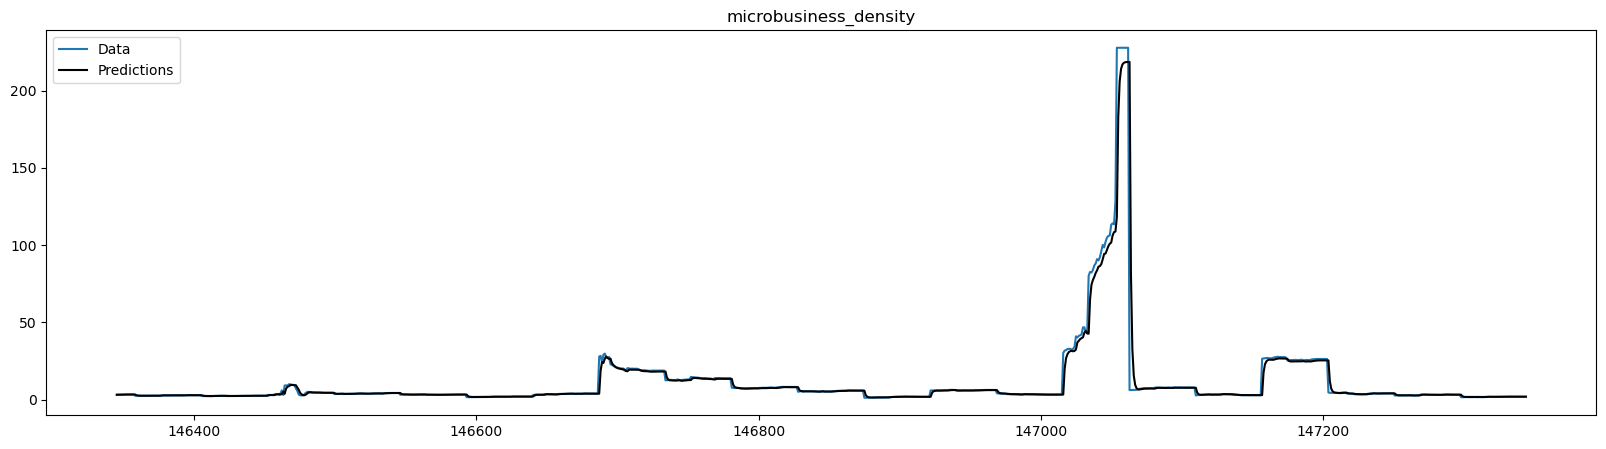

In [153]:
x.summary()
model.plot_predict_is(h=1000 ,figsize=(20, 5)) #h=どれだけの数を予測するか

In [162]:
result = model.predict(h=len(train_test)-1)

In [121]:
result = result.sort_index(ascending=False).reset_index(drop=True)
result = result.append({'microbusiness_density':0.0}, ignore_index=True)

In [163]:
result

,microbusiness_density
147335,1.873130
147336,1.931327
147337,1.987811
147338,2.042631
147339,2.095837
147340,2.147477
147341,2.197596
147342,2.246239
147343,2.293451
147344,2.339272


In [164]:
train_test

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,mbd_lag_1,mbd_lag_2,mbd_lag_3,...,deviation,cat_mean,cat_min,cat_max,cat_max-min,OrderedTE,state_LE,county_LE,divergence,train_or_test
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.000000,NaN,NaN,NaN,...,3.007682,3.164535,2.884870,3.463856,0.578985,3.817671,0.000000,82.000000,0.000000,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.000000,3.007682,NaN,NaN,...,-0.122812,3.164535,2.884870,3.463856,0.578985,3.412676,0.000000,82.000000,0.000000,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.000000,2.884870,3.007682,NaN,...,0.170973,3.164535,2.884870,3.463856,0.578985,3.236741,0.000000,82.000000,0.000000,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.000000,3.055843,2.884870,3.007682,...,-0.062610,3.164535,2.884870,3.463856,0.578985,3.191516,0.000000,82.000000,0.000000,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.000000,2.993233,3.055843,2.884870,...,0.000000,3.164535,2.884870,3.463856,0.578985,3.151860,0.000000,82.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,1.785395,100.000000,1.785395,1.785395,1.803249,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,1.785395,100.000000,1.785395,1.785395,1.803249,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,1.785395,100.000000,1.785395,1.785395,1.803249,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,1.785395,100.000000,1.785395,1.785395,1.803249,...,0.000000,1.663503,1.519214,1.803249,0.284036,1.715613,50.000000,1793.000000,0.000000,1


In [148]:
#最初にtrain?testをカットしない場合。
cut_index = train_test[train_test["train_or_test"] == 1].index
result_index = result.index
result_end = result[result_index.isin(cut_index)]
result_end = result_end.reset_index(drop=True)
result_end

,microbusiness_density
0,3.214793
1,3.233487
2,3.251629
3,3.269238
4,3.286329
...,...
25075,3.849676
25076,3.849676
25077,3.849676
25078,3.849676


In [149]:
#DFに書き込むためのデータを呼び出す。
test2 = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

In [150]:
#答えをDFにする
test2["microbusiness_density"] = result["microbusiness_density"]

#df_answer = pd.DataFrame(data={"row_id":test2["row_id"],,"microbusiness_density":predicted_2})
#df_answer

#答えをソート　提出例に合わせて作る
test2 = test2.sort_values(["first_day_of_month","cfips"])
test2 = test2.drop(["first_day_of_month","cfips"],axis=1)

In [151]:
test2

,row_id,microbusiness_density
0,1001_2022-11-01,3.214793
1,1003_2022-11-01,3.233487
2,1005_2022-11-01,3.251629
3,1007_2022-11-01,3.269238
4,1009_2022-11-01,3.286329
...,...,...
25075,56037_2023-06-01,3.849676
25076,56039_2023-06-01,3.849676
25077,56041_2023-06-01,3.849676
25078,56043_2023-06-01,3.849676


In [4]:
sample

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671
...,...,...
25075,56037_2023-06-01,3.817671
25076,56039_2023-06-01,3.817671
25077,56041_2023-06-01,3.817671
25078,56043_2023-06-01,3.817671


In [152]:
#完成したCSVを名前を変えて保存する #インデックス（行番号）なし
test2.to_csv('/kaggle/working/godaddy74.csv',index = False)

# # **ARIMAXモデル**

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: microbusiness_density               Method: MLE                                       
Start Date: 1                                           Log Likelihood: -244469.9577                      
End Date: 122264                                        AIC: 488949.9154                                  
Number of observations: 122264                          BIC: 488998.4851                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.766      0.0021     363.192  0.0      (0.7618 | 0.7701)        
MA(1)                                

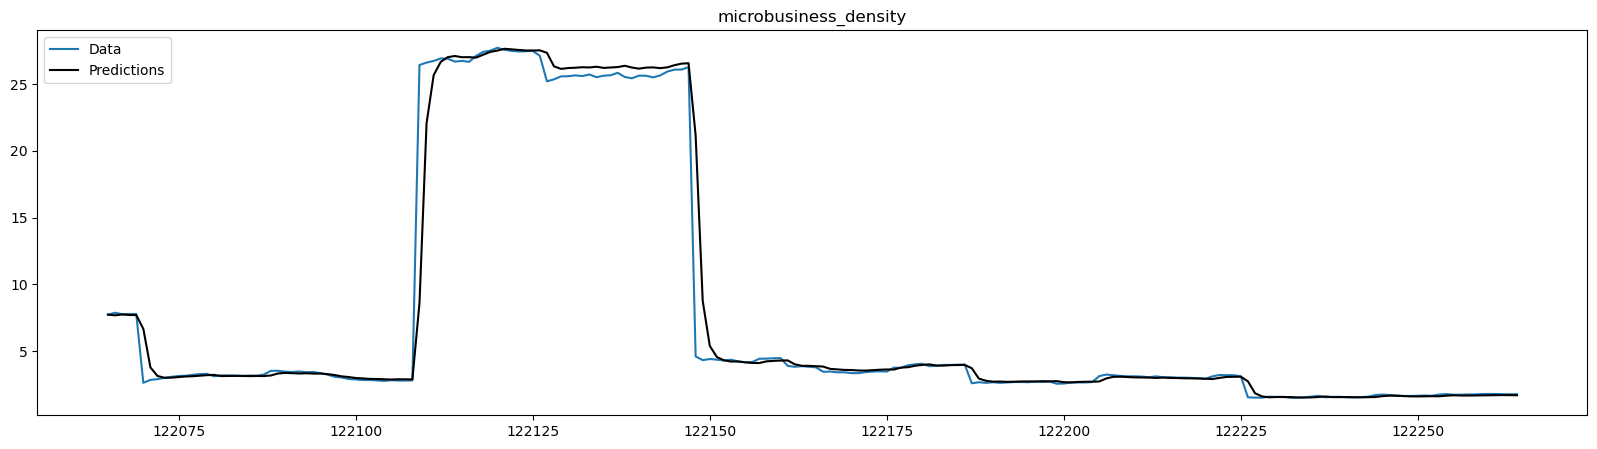

In [107]:
#時系列データにはない外部要因を入れて評価したい場合があります。そのような場合はARIMAXを使用します。
#予測後にパラメータを加えて再度予測
model = pf.ARIMAX(data=train, formula='microbusiness_density~1+cat_mean',
                 ar=1, ma=1, family=pf.Normal())
x = model.fit('MLE')

x.summary()
model.plot_predict_is(h=200 ,figsize=(20, 5)) #h=どれだけの数を予測するか

In [116]:
model.predict(h=20)

TypeError: 'NoneType' object is not subscriptable

In [155]:
pd.set_option('display.max_rows', 5000)
test


,row_id,cfips,first_day_of_month,train_or_test
0,1001_2022-11-01,1001,2022-11-01,1
1,1003_2022-11-01,1003,2022-11-01,1
2,1005_2022-11-01,1005,2022-11-01,1
3,1007_2022-11-01,1007,2022-11-01,1
4,1009_2022-11-01,1009,2022-11-01,1
...,...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01,1
25076,56039_2023-06-01,56039,2023-06-01,1
25077,56041_2023-06-01,56041,2023-06-01,1
25078,56043_2023-06-01,56043,2023-06-01,1
